This notebook calculates air-sea CO2 fluxes based on the pCO2 reconstructions using SOCAT + USV Saildrone sampling masks.

We calculate fluxes separately for reconstructions for each model in the LET (CESM, CanESM2 and GFDL) and then combine.

This notebook was created by Thea Hatlen Heimdal and Amanda Fay, in collaboration with Julius Busecke

In [ ]:
import xarray as xr
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cmocean as cm 
import math

### Water vapor correction function

In [2]:
def calc_pco2_from_xco2(xco2,pres,T,S):

# %calculate pressure at 100% humidity
    a1 = -7.85951783
    a2 = 1.84408259
    a4 = 22.6807411 
    a5 = -15.9618719
    a3 = -11.7866497
    a6 = 1.80122502

# %T=298.15;
    Tc = 647.096
    pc = 22064000
    # %S=35;
    T=T+273.15

    Phi=(1-(T/Tc))
    lnform=(Tc/T)*(a1*Phi+a2*Phi**(1.5)+a3*Phi**3+a4*Phi**(3.5)+a5*Phi**(4)+a6*Phi**(7.5))
    Psig=np.exp(lnform)*pc

    molarity=(31.998*S)/(10**3-1.005*S)
    Psi=0.90799-0.08992*(0.5*molarity)+0.18458*(0.5*molarity)**2-0.07395*(0.5*molarity)**3-0.00221*(0.5*molarity)**4
    Psigcor=Psig*np.exp(-0.018*Psi*molarity)

# %convert pressure from hPa to Pascal
    pres=pres*100

# %calculate pCO2 wet in Pa
    pco2_Pa= (xco2*10**-6)*(pres-Psigcor)

# %and convert into muatm
    pco2=pco2_Pa*9.8692326671601E-6*10**6

    return pco2

### <font color='orange'>CESM</font> 

#### Bring in ocean pCO2 and XCO2

In [3]:
dsm = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/pCO2_2D_mon_CESM021_1x1_198201-201701.nc')
model = dsm.pCO2
#load in the xco2 from cesm
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')
xco2 = ds.XCO2
del ds

#want to calculate wv corr atm pco2
#get pressure

ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/pATM_2D_mon_CESM021_1x1_198201-201701.nc')
pres = ds.pATM
#sst
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/SST_2D_mon_CESM021_1x1_198201-201701.nc')
sst = ds.SST
#sss
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/SSS_2D_mon_CESM021_1x1_198201-201701.nc')
sss = ds.SSS

#ensure they all have the same time

model['time'] = model.time.data.astype('datetime64[s]')  - np.timedelta64(1, 'D')
sst['time'] = model['time']
sss['time'] = model['time']
pres['time'] = model['time']
xco2['time'] = model['time']

pres_hpa = pres*1013.25

cesm_calc_atm_wvcorr = calc_pco2_from_xco2(xco2,pres_hpa,sst,sss)

path_LET = "/local/data/artemis/workspace/theimdal/saildrone/LET_pickle_files/members_LET_dict_CESM.pickle" #without MPI

### Bring in CESM ocean pCO2 reconstructions

In [4]:
#Paths for runs
with open(path_LET,'rb') as handle:
    mems_dict = pickle.load(handle)

In [5]:
datasets_ens = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):

        truth_path = f"/data/artemis/simulations/LET/{ens}/member_{member}/pCO2_2D_mon_{ens}{member}_1x1_198201-201701.nc"
        #recon_path = f"/data/artemis/workspace/theimdal/SOCAT/models/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        recon_path = f"/data/artemis/workspace/theimdal/GO-BGC/models/500_floats/bias4/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, **kwargs).pCO2
        recon = xr.open_dataset(recon_path, **kwargs).pCO2_unseen_recon
        
        # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        recon = recon.assign_coords(status='reconstructed')
        
        # make sure they have the same time coordinates
        truth = truth.assign_coords(time=recon['time'].data)
        
        member_ds = xr.concat([truth, recon], dim='status')
        
        # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens.append(ds_ens)
    
ds_both = xr.concat(datasets_ens, dim='ensemble', join='override') 

In [6]:
#replace all 0 by nans
ds_both = ds_both.where(ds_both != 0.)

#rename pCO2 atm variable
CESM_pco2atm = cesm_calc_atm_wvcorr

### paths
seaflux_file = '/data/artemis/observations/SeaFlux/SeaFlux_v2022.01_no_pco2.nc'
ocean_area_file = '/data/artemis/observations/SOCOM/extra_files/SeaFlux_v2021.04_area_ocean.nc'

recon_ens = ds_both
recon_ens = recon_ens.sel(time=slice("1983-01-01","2016-12-31"))

CESM_pco2atm = CESM_pco2atm.sel(time=slice("1983-01-01","2016-12-31"))

start_yearmonth = str(recon_ens.time.min().data.astype('datetime64[s]').item().strftime('%Y-%m'))
end_yearmonth = str(recon_ens.time.max().data.astype('datetime64[s]').item().strftime('%Y-%m'))
#print(f'{start_yearmonth} to {end_yearmonth}')

seaflux = xr.open_dataset(seaflux_file)

kw1 = seaflux.kw_cmhr.sel(wind=["ERA5"])
kw = kw1 * 87.6  # --> cm/hr now m/yr
kw = kw.where(kw > 0)  # solubility (mol/m3/uatm) and kw converted from (cm/hr) to (m/s)
                        #should always be over 0 so this prevents againsts issues in other releases
                        #update so that kw1 is nan if 0 ever (so mean is not too low)
k0 = seaflux.sol_molm3uatm#[1:,:,:] # mol / m3 / uatm
icef = seaflux.ice_frac # ice fraction 
ice_weighting = 1 - icef.fillna(0)
#atmos = seaflux.atm_pco2_uatm #uatm

#filter to same time frame
#atmos_filter = atmos.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
k0_filter = k0.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
kw_filter = kw.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
ice_weighting_filter = ice_weighting.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 

#Now process reconstructed pco2
recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')  
recon_ens['time'] = k0_filter['time'] 

lon2 = np.where(recon_ens.xlon>180,recon_ens.xlon-360,recon_ens.xlon)
recon_ens['xlon'] = (lon2)
recon_ens = recon_ens.sortby(recon_ens.xlon)

if True: 
    pco2_ens = recon_ens.rename({'xlon': 'lon'})
    pco2_ens = pco2_ens.rename({'ylat': 'lat'})
    pco2_ens = pco2_ens.transpose('time','lat','lon',...)

spco2_ens = pco2_ens
#delta_ens = spco2_ens - atmos_filter
#delta_ens = spco2_ens - pco2atm2

#Now process pco2 atm
CESM_pco2atm['time'] = CESM_pco2atm.time.data.astype('datetime64[s]')
CESM_pco2atm['time'] = recon_ens['time']

lon2 = np.where(CESM_pco2atm.xlon>180,CESM_pco2atm.xlon-360,CESM_pco2atm.xlon)
CESM_pco2atm['xlon'] = (lon2)
CESM_pco2atm = CESM_pco2atm.sortby(CESM_pco2atm.xlon)

if True: 
    pco2atm = CESM_pco2atm.rename({'xlon': 'lon'})
    pco2atm = pco2atm.rename({'ylat': 'lat'})
    pco2atm = pco2atm.transpose('time','lat','lon',...)

pco2atm2 = pco2atm

delta_ens = spco2_ens - pco2atm2

#calculate flux
flux_ens_CESM =(   k0_filter
            * kw_filter
            * delta_ens 
            * ice_weighting_filter
           ) # mol/m2/yr

#remove flux calc for unmasked area for truth reconstruction 

flux_truth = flux_ens_CESM.sel(status="truth")
flux_recon = flux_ens_CESM.sel(status="reconstructed")

flux_truth_masked = xr.where(flux_recon.notnull(),flux_truth,-1000)
flux_truth_masked = flux_truth_masked.where(flux_truth_masked != -1000)

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


### Enhancing / Summarizing Flux

In [7]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_CESM = flux_ens_co2_truth.groupby("time.year").mean("time")

In [8]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_CESM = flux_ens_co2_recon.groupby("time.year").mean("time")

In [9]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-35))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(-90,-35))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_SO_CESM = flux_ens_co2_truth.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [16]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-35))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(-90,-35))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_SO_CESM = flux_ens_co2_recon.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [17]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(0,90))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(0,90))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_NH_CESM = flux_ens_co2_truth.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [18]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(0,90))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(0,90))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_NH_CESM = flux_ens_co2_recon.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


### <font color='purple'>GFDL</font> 

### Bring in pco2 atm for all 25 members of GFDL

In [9]:
path_LET = "/local/data/artemis/workspace/theimdal/saildrone/LET_pickle_files/members_LET_dict_GFDL.pickle" #without MPI

with open(path_LET,'rb') as handle:
    mems_dict = pickle.load(handle)

In [10]:
datasets_ens = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):

        truth_path = f"/data/artemis/simulations/LET/{ens}/member_{member}/pCO2ATM_2D_mon_{ens}{member}_1x1_198201-201701.nc"
        recon_path = f"/data/artemis/workspace/theimdal/SOCAT/models/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, **kwargs).pCO2ATM
        recon = xr.open_dataset(recon_path, **kwargs).pCO2_unseen_recon
        
        # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        recon = recon.assign_coords(status='reconstructed')
        
        # make sure they have the same time coordinates
        truth = truth.assign_coords(time=recon['time'].data)
        
        member_ds = xr.concat([truth, recon], dim='status')
        
        # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens.append(ds_ens)
    
ds_GFDL = xr.concat(datasets_ens, dim='ensemble', join='override') 

In [11]:
GFDL_pco2atm = ds_GFDL.sel(status="truth")

### Bring in GFDL ocean pCO2 reconstructions

In [12]:
datasets_ens = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):

        truth_path = f"/data/artemis/simulations/LET/{ens}/member_{member}/pCO2_2D_mon_{ens}{member}_1x1_198201-201701.nc"
        #recon_path = f"/data/artemis/workspace/theimdal/SOCAT/models/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        recon_path = f"/data/artemis/workspace/theimdal/GO-BGC/models/500_floats/bias4/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, **kwargs).pCO2
        recon = xr.open_dataset(recon_path, **kwargs).pCO2_unseen_recon
        
        # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        recon = recon.assign_coords(status='reconstructed')
        
        # make sure they have the same time coordinates
        truth = truth.assign_coords(time=recon['time'].data)
        
        member_ds = xr.concat([truth, recon], dim='status')
        
        # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens.append(ds_ens)
    
ds_both = xr.concat(datasets_ens, dim='ensemble', join='override') 

In [13]:
#replace all 0 by nans
ds_both = ds_both.where(ds_both != 0.)

recon_ens = ds_both
recon_ens = recon_ens.sel(time=slice("1983-01-01","2016-12-31"))


GFDL_pco2atm = GFDL_pco2atm.sel(time=slice("1983-01-01","2016-12-31"))


start_yearmonth = str(recon_ens.time.min().data.astype('datetime64[s]').item().strftime('%Y-%m'))
end_yearmonth = str(recon_ens.time.max().data.astype('datetime64[s]').item().strftime('%Y-%m'))
#print(f'{start_yearmonth} to {end_yearmonth}')

kw1 = seaflux.kw_cmhr.sel(wind=["ERA5"])
kw = kw1 * 87.6  # --> cm/hr now m/yr
kw = kw.where(kw > 0)  # solubility (mol/m3/uatm) and kw converted from (cm/hr) to (m/s)
                        #should always be over 0 so this prevents againsts issues in other releases
                        #update so that kw1 is nan if 0 ever (so mean is not too low)
k0 = seaflux.sol_molm3uatm#[1:,:,:] # mol / m3 / uatm
icef = seaflux.ice_frac # ice fraction 
ice_weighting = 1 - icef.fillna(0)
#atmos = seaflux.atm_pco2_uatm #uatm

#filter to same time frame
#atmos_filter = atmos.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
k0_filter = k0.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
kw_filter = kw.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
ice_weighting_filter = ice_weighting.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 

#Now process reconstructed pco2
recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')  
recon_ens['time'] = k0_filter['time'] 

lon2 = np.where(recon_ens.xlon>180,recon_ens.xlon-360,recon_ens.xlon)
recon_ens['xlon'] = (lon2)
recon_ens = recon_ens.sortby(recon_ens.xlon)

if True: 
    pco2_ens = recon_ens.rename({'xlon': 'lon'})
    pco2_ens = pco2_ens.rename({'ylat': 'lat'})
    pco2_ens = pco2_ens.transpose('time','lat','lon',...)

spco2_ens = pco2_ens
#delta_ens = spco2_ens - atmos_filter
#delta_ens = spco2_ens - pco2atm2

#Now process pco2 atm
GFDL_pco2atm['time'] = GFDL_pco2atm.time.data.astype('datetime64[s]')
GFDL_pco2atm['time'] = recon_ens['time']

lon2 = np.where(GFDL_pco2atm.xlon>180,GFDL_pco2atm.xlon-360,GFDL_pco2atm.xlon)
GFDL_pco2atm['xlon'] = (lon2)
GFDL_pco2atm = GFDL_pco2atm.sortby(GFDL_pco2atm.xlon)

if True: 
    pco2atm = GFDL_pco2atm.rename({'xlon': 'lon'})
    pco2atm = pco2atm.rename({'ylat': 'lat'})
    pco2atm = pco2atm.transpose('time','lat','lon',...)

pco2atm2 = pco2atm

delta_ens = spco2_ens - pco2atm2

#calculate flux
flux_ens_GFDL =(   k0_filter
            * kw_filter
            * delta_ens 
            * ice_weighting_filter
           ) # mol/m2/yr

#remove flux calc for unmasked area for truth reconstruction 

flux_truth = flux_ens_GFDL.sel(status="truth")
flux_recon = flux_ens_GFDL.sel(status="reconstructed")

flux_truth_masked = xr.where(flux_recon.notnull(),flux_truth,-1000)
flux_truth_masked = flux_truth_masked.where(flux_truth_masked != -1000)

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

### Enhancing / Summarizing Flux

In [14]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_GFDL = flux_ens_co2_truth.groupby("time.year").mean("time")

In [15]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_GFDL = flux_ens_co2_recon.groupby("time.year").mean("time")

In [16]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-35))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(-90,-35))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_SO_GFDL = flux_ens_co2_truth.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [17]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-35))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(-90,-35))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_SO_GFDL = flux_ens_co2_recon.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [18]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(0,90))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(0,90))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_NH_GFDL = flux_ens_co2_truth.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [19]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(0,90))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(0,90))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_NH_GFDL = flux_ens_co2_recon.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


### <font color='orange'>CanESM2</font> 

#### Bring in ocean pCO2 and XCO2

In [16]:
dsmc = xr.open_dataset('/data/artemis/simulations/LET/CanESM2/member_r1r9/pCO2_2D_mon_CanESM2r1r9_1x1_198201-201712.nc')
modelc = dsmc.pCO2

#load in the xco2 from cesm
ds = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')
xco2 = ds.XCO2
del ds

#want to calculate wv corr atm pco2
#get pressure
ds = xr.open_dataset('/data/artemis/simulations/LET/CanESM2/member_r1r9/pATM_2D_mon_CanESM2r1r9_1x1_198201-201712.nc')
pres = ds.pATM
#sst
ds = xr.open_dataset('/data/artemis/simulations/LET/CanESM2/member_r1r9/SST_2D_mon_CanESM2r1r9_1x1_198201-201712.nc')
sst = ds.SST
#sss
ds = xr.open_dataset('/data/artemis/simulations/LET/CanESM2/member_r1r9/SSS_2D_mon_CanESM2r1r9_1x1_198201-201712.nc')
sss = ds.SSS

#ensure they all have the same time

modelc['time'] = modelc.time.data.astype('datetime64[s]')  + np.timedelta64(14, 'D')
sst['time'] = modelc['time']
sss['time'] = modelc['time']
pres['time'] = modelc['time']
xco2['time'] = modelc['time']

pres_hpa = pres*1013.25

#do just pres *xco2
can_atm_nocorr = pres*xco2

#this is just to bring in nans over land
can_calc_atm_wvcorr = calc_pco2_from_xco2(xco2,pres_hpa,sst,sss)

can_atm_nocorr = can_atm_nocorr.where(can_calc_atm_wvcorr.notnull(), -1000)
can_atm_nocorr = can_atm_nocorr.where(can_atm_nocorr != -1000) #make -1000s nans

dsm = xr.open_dataset('/data/artemis/simulations/LET/CESM/member_021/pCO2_2D_mon_CESM021_1x1_198201-201701.nc')
model = dsm.pCO2

#ensure they have the same time
modelc['time'] = model['time']

#ocean pCO2
#have to fill in mask for modelc or else really low mean values
modelc = modelc.where(model.notnull(), -1000)
modelc = modelc.where(modelc != -1000) #make -1000s nans
modelc = modelc.where(modelc != 0.)

### Bring in CanESM2 ocean pCO2 reconstructions

In [17]:
path_LET = "/local/data/artemis/workspace/theimdal/saildrone/LET_pickle_files/members_LET_dict_CanESM2.pickle" #without MPI

with open(path_LET,'rb') as handle:
    mems_dict = pickle.load(handle)

In [18]:
datasets_ens = []
for ens, mem_list in mems_dict.items():
    datasets_member = []
    for n_member, member in enumerate(mem_list):

        truth_path = f"/data/artemis/simulations/LET/{ens}/member_{member}/pCO2_2D_mon_{ens}{member}_1x1_198201-201712.nc"
        #recon_path = f"/data/artemis/workspace/theimdal/SOCAT/models/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        recon_path = f"/data/artemis/workspace/theimdal/GO-BGC/models/500_floats/bias4/reconstructions/xg/{ens}/member_{member}/recon_pCO2DIC_pCO2_2D_mon_{ens}_{member}_1x1_198201-201701.nc"
        kwargs = dict(chunks={'time':-1})
        
        truth = xr.open_dataset(truth_path, **kwargs).pCO2
        recon = xr.open_dataset(recon_path, **kwargs).pCO2_unseen_recon
        
        # assign_dimension coordinates
        truth = truth.assign_coords(status='truth')
        recon = recon.assign_coords(status='reconstructed')
        
        # make sure they have the same time coordinates
        truth = truth.assign_coords(time=recon['time'].data)
        
        member_ds = xr.concat([truth, recon], dim='status')
        
        # add member_dimension and coordinate
        member_ds = member_ds.assign_coords(n_member=n_member, member=member)
        
        datasets_member.append(member_ds)
    
    ds_ens = xr.concat(datasets_member, dim='n_member')
    ds_ens = ds_ens.assign_coords(ensemble=ens)
    
    
    datasets_ens.append(ds_ens)
    
ds_both = xr.concat(datasets_ens, dim='ensemble', join='override') 

In [19]:
#replace all 0 by nans
ds_both = ds_both.where(ds_both != 0.)

#rename pCO2 atm variable
CanESM2_pco2atm = can_atm_nocorr

recon_ens = ds_both
recon_ens = recon_ens.sel(time=slice("1983-01-01","2016-12-31"))


CanESM2_pco2atm = CanESM2_pco2atm.sel(time=slice("1983-01-01","2016-12-31"))


start_yearmonth = str(recon_ens.time.min().data.astype('datetime64[s]').item().strftime('%Y-%m'))
end_yearmonth = str(recon_ens.time.max().data.astype('datetime64[s]').item().strftime('%Y-%m'))
#print(f'{start_yearmonth} to {end_yearmonth}')

kw1 = seaflux.kw_cmhr.sel(wind=["ERA5"])
kw = kw1 * 87.6  # --> cm/hr now m/yr
kw = kw.where(kw > 0)  # solubility (mol/m3/uatm) and kw converted from (cm/hr) to (m/s)
                        #should always be over 0 so this prevents againsts issues in other releases
                        #update so that kw1 is nan if 0 ever (so mean is not too low)
k0 = seaflux.sol_molm3uatm#[1:,:,:] # mol / m3 / uatm
icef = seaflux.ice_frac # ice fraction 
ice_weighting = 1 - icef.fillna(0)
#atmos = seaflux.atm_pco2_uatm #uatm

#filter to same time frame
#atmos_filter = atmos.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
k0_filter = k0.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
kw_filter = kw.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 
ice_weighting_filter = ice_weighting.sel(time=slice(str(start_yearmonth),str(end_yearmonth))) 

#Now process reconstructed pco2
recon_ens['time'] = recon_ens.time.data.astype('datetime64[s]')  
recon_ens['time'] = k0_filter['time'] 

lon2 = np.where(recon_ens.xlon>180,recon_ens.xlon-360,recon_ens.xlon)
recon_ens['xlon'] = (lon2)
recon_ens = recon_ens.sortby(recon_ens.xlon)

if True: 
    pco2_ens = recon_ens.rename({'xlon': 'lon'})
    pco2_ens = pco2_ens.rename({'ylat': 'lat'})
    pco2_ens = pco2_ens.transpose('time','lat','lon',...)

spco2_ens = pco2_ens
#delta_ens = spco2_ens - atmos_filter
#delta_ens = spco2_ens - pco2atm2

#Now process pco2 atm
CanESM2_pco2atm['time'] = CanESM2_pco2atm.time.data.astype('datetime64[s]')
CanESM2_pco2atm['time'] = recon_ens['time']

lon2 = np.where(CanESM2_pco2atm.xlon>180,CanESM2_pco2atm.xlon-360,CanESM2_pco2atm.xlon)
CanESM2_pco2atm['xlon'] = (lon2)
CanESM2_pco2atm = CanESM2_pco2atm.sortby(CanESM2_pco2atm.xlon)

if True: 
    pco2atm = CanESM2_pco2atm.rename({'xlon': 'lon'})
    pco2atm = pco2atm.rename({'ylat': 'lat'})
    pco2atm = pco2atm.transpose('time','lat','lon',...)

pco2atm2 = pco2atm

delta_ens = spco2_ens - pco2atm2

#calculate flux
flux_ens_CanESM2 =(   k0_filter
            * kw_filter
            * delta_ens 
            * ice_weighting_filter
           ) # mol/m2/yr

#remove flux calc for unmasked area for truth reconstruction 

flux_truth = flux_ens_CanESM2.sel(status="truth")
flux_recon = flux_ens_CanESM2.sel(status="reconstructed")

flux_truth_masked = xr.where(flux_recon.notnull(),flux_truth,-1000)
flux_truth_masked = flux_truth_masked.where(flux_truth_masked != -1000)

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


### Enhancing / Summarizing Flux

In [20]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_CanESM2 = flux_ens_co2_truth.groupby("time.year").mean("time")

In [21]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_CanESM2 = flux_ens_co2_recon.groupby("time.year").mean("time")

In [36]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-35))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(-90,-35))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_SO_CanESM2 = flux_ens_co2_truth.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [37]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(-90,-35))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(-90,-35))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_SO_CanESM2 = flux_ens_co2_recon.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [38]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(0,90))

flux_tmp_truth = flux_truth_masked * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_truth = flux_tmp_truth.sel(lat=slice(0,90))
flux_region_ens_truth = flux_tmp_truth.sum(['lat','lon']) 
flux_ens_co2_truth = flux_region_ens_truth.where(flux_region_ens_truth!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_truth.attrs['units'] = 'g/yr'
annual_fluxes_truth_NH_CanESM2 = flux_ens_co2_truth.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [39]:
sarea = xr.open_dataset(ocean_area_file)
area = sarea.area_ocean.sel(lat=slice(0,90))

flux_tmp_recon = flux_recon * area *12     # g/yr flux_ens is in mol/m2/yr so *area gets you mol/yr and then *12 is g/yr
flux_tmp_recon = flux_tmp_recon.sel(lat=slice(0,90))
flux_region_ens_recon = flux_tmp_recon.sum(['lat','lon']) 
flux_ens_co2_recon = flux_region_ens_recon.where(flux_region_ens_recon!=0) #sum over the region to get total flux in Pg/yr
flux_ens_co2_recon.attrs['units'] = 'g/yr'
annual_fluxes_recon_NH_CanESM2 = flux_ens_co2_recon.groupby("time.year").mean("time")

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


### Merge flux from the three models

In [22]:
flux_truth_all_global = xr.concat([annual_fluxes_truth_GFDL, annual_fluxes_truth_CESM, annual_fluxes_truth_CanESM2], dim='model')
flux_truth_all_global_timeline = flux_truth_all_global.mean(["model", "n_member", "ensemble", "wind"])
flux_recon_all_global = xr.concat([annual_fluxes_recon_GFDL, annual_fluxes_recon_CESM, annual_fluxes_recon_CanESM2], dim='model')
flux_recon_all_global_timeline = flux_recon_all_global.mean(["model", "n_member", "ensemble", "wind"])

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing

In [41]:
flux_truth_all_SO = xr.concat([annual_fluxes_truth_SO_GFDL, annual_fluxes_truth_SO_CESM, annual_fluxes_truth_SO_CanESM2], dim='model')
flux_truth_all_SO_timeline = flux_truth_all_SO.mean(["model", "n_member", "ensemble", "wind"])
flux_recon_all_SO = xr.concat([annual_fluxes_recon_SO_GFDL, annual_fluxes_recon_SO_CESM, annual_fluxes_recon_SO_CanESM2], dim='model')
flux_recon_all_SO_timeline = flux_recon_all_SO.mean(["model", "n_member", "ensemble", "wind"])

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing

In [42]:
flux_truth_all_NH = xr.concat([annual_fluxes_truth_NH_GFDL, annual_fluxes_truth_NH_CESM, annual_fluxes_truth_NH_CanESM2], dim='model')
flux_truth_all_NH_timeline = flux_truth_all_NH.mean(["model", "n_member", "ensemble", "wind"])
flux_recon_all_NH = xr.concat([annual_fluxes_recon_NH_GFDL, annual_fluxes_recon_NH_CESM, annual_fluxes_recon_NH_CanESM2], dim='model')
flux_recon_all_NH_timeline = flux_recon_all_NH.mean(["model", "n_member", "ensemble", "wind"])

/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing number of chunks by factor of 25
  result = blockwise(
/home/theimdal/.conda/envs/cesm_play/lib/python3.8/site-packages/dask/array/core.py:4293: PerformanceWarning: Increasing

### Make figures

## Testbed mean

#### Southern Ocean

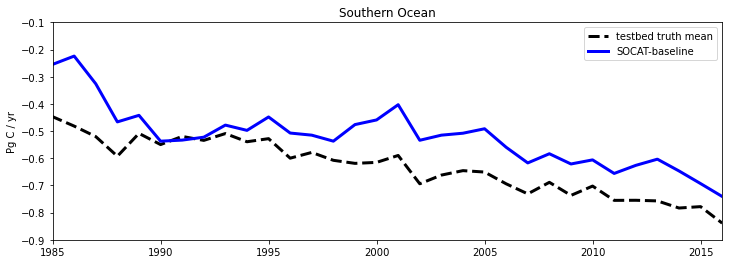

In [43]:
fig = plt.subplots(1,1,figsize=(12,4))


plt.plot(range(1983,2017),flux_truth_all_SO_timeline/(1e15),linewidth=3, label='testbed truth mean', color='black', linestyle='--')
plt.plot(range(1983,2017),flux_recon_all_SO_timeline/(1e15),linewidth=3, label='SOCAT-baseline', color='blue')



# plt.grid(True)
plt.title(f"Southern Ocean")
plt.legend()
plt.ylabel('Pg C / yr')
plt.ylim(-0.9,-0.1)
plt.xlim(1985,2016)
plt.legend();

#plt.savefig("pCO2Resid_Flux_DataProducts_Flux_1985-2019.eps",format="eps",dpi=1200)

#### Northern Hemisphere

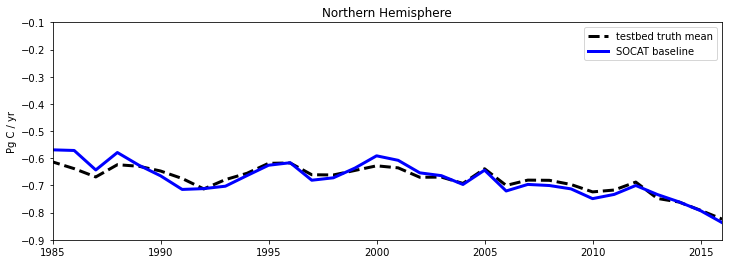

In [44]:
fig = plt.subplots(1,1,figsize=(12,4))


plt.plot(range(1983,2017),flux_truth_all_NH_timeline/(1e15),linewidth=3, label='testbed truth mean', color='black', linestyle='--')
plt.plot(range(1983,2017),flux_recon_all_NH_timeline/(1e15),linewidth=3, label='SOCAT baseline', color='blue')



# plt.grid(True)
plt.title(f"Northern Hemisphere")
plt.legend()
plt.ylabel('Pg C / yr')
plt.ylim(-0.9,-0.1)
plt.xlim(1985,2016)
plt.legend();

#plt.savefig("pCO2Resid_Flux_DataProducts_Flux_1985-2019.eps",format="eps",dpi=1200)

### Mean per model

(2000.0, 2016.0)

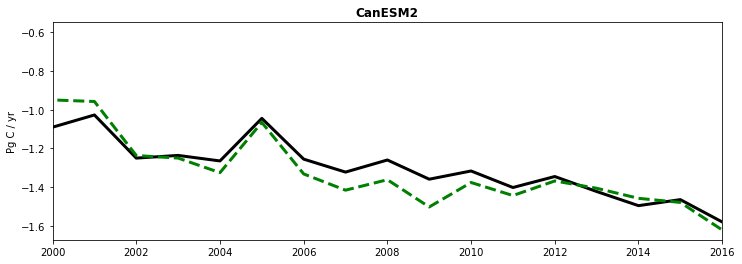

In [24]:
fig = plt.subplots(1,1,figsize=(12,4))

plt.plot(range(1983,2017),annual_fluxes_truth_CanESM2.mean(["wind", "n_member", "ensemble"])/(1e15),linewidth=3, label='Model truth', color='black')
plt.plot(range(1983,2017),annual_fluxes_recon_CanESM2.mean(["wind", "ensemble", "n_member"])/(1e15),linewidth=3, label='Historical_baseline', color='green', linestyle='--')

# plt.grid(True)
plt.title(f"CanESM2", weight='bold')

plt.ylabel('Pg C / yr')
#plt.ylim(-2.0,0.6)
plt.xlim(2000,2016)
#plt.legend()

#plt.savefig('/home/theimdal/CanESM2_flux_global_historical_baseline.png', dpi=300, bbox_inches="tight")

(2000.0, 2016.0)

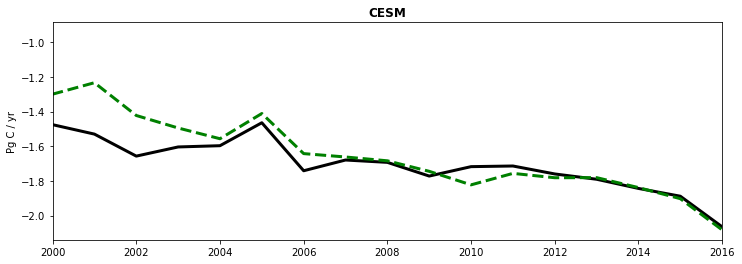

In [25]:
fig = plt.subplots(1,1,figsize=(12,4))

plt.plot(range(1983,2017),annual_fluxes_truth_CESM.mean(["wind", "n_member", "ensemble"])/(1e15),linewidth=3, label='Model truth', color='black')
plt.plot(range(1983,2017),annual_fluxes_recon_CESM.mean(["wind", "ensemble", "n_member"])/(1e15),linewidth=3, label='Historical_baseline', color='green', linestyle='--')

# plt.grid(True)
plt.title(f"CESM", weight='bold')

plt.ylabel('Pg C / yr')
#plt.ylim(-2.0,0.6)
plt.xlim(2000,2016)
#plt.legend()

#plt.savefig('/home/theimdal/CESM_flux_global_historical_baseline.png', dpi=300, bbox_inches="tight")

(2000.0, 2016.0)

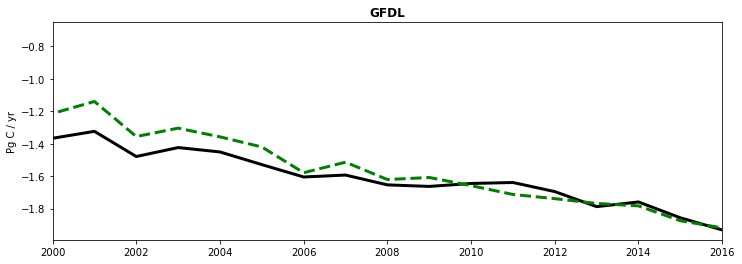

In [26]:
fig = plt.subplots(1,1,figsize=(12,4))

plt.plot(range(1983,2017),annual_fluxes_truth_GFDL.mean(["wind", "n_member", "ensemble"])/(1e15),linewidth=3, label='Model truth', color='black')
plt.plot(range(1983,2017),annual_fluxes_recon_GFDL.mean(["wind", "ensemble", "n_member"])/(1e15),linewidth=3, label='Historical_baseline', color='green', linestyle='--')

# plt.grid(True)
plt.title(f"GFDL", weight='bold')

plt.ylabel('Pg C / yr')
#plt.ylim(-2.0,0.6)
plt.xlim(2000,2016)
#plt.legend()

#plt.savefig('/home/theimdal/GFDL_flux_global_historical_baseline.png', dpi=300, bbox_inches="tight")

## Model spread

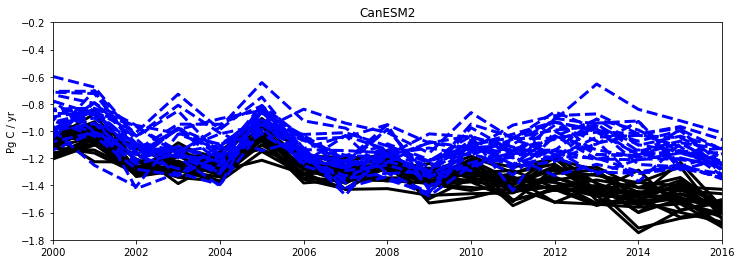

In [23]:
fig = plt.subplots(1,1,figsize=(12,4))

plt.plot(range(1983,2017),annual_fluxes_truth_CanESM2.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='mean truth CanCESM2', color='black')
plt.plot(range(1983,2017),annual_fluxes_recon_CanESM2.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon CanCESM2', color='blue', linestyle='--')


# plt.grid(True)
plt.title(f"CanESM2")
#plt.legend()
plt.ylabel('Pg C / yr')
plt.ylim(-1.8,-0.2)
plt.xlim(2000,2016)
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');

plt.savefig('/home/theimdal/CanESM_flux_global_historical_bias.png', dpi=300, bbox_inches="tight")

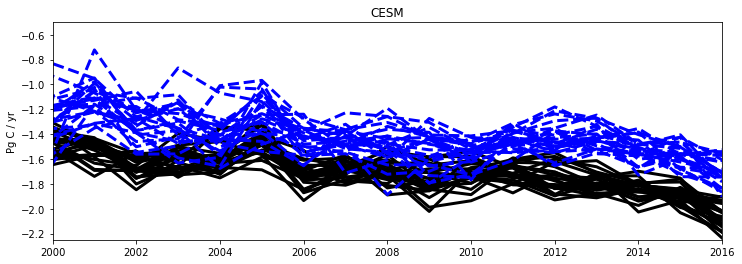

In [24]:
fig = plt.subplots(1,1,figsize=(12,4))

plt.plot(range(1983,2017),annual_fluxes_truth_CESM.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='mean truth CanCESM2', color='black')
plt.plot(range(1983,2017),annual_fluxes_recon_CESM.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon CanCESM2', color='blue', linestyle='--')


# plt.grid(True)
plt.title(f"CESM")
#plt.legend()
plt.ylabel('Pg C / yr')
plt.ylim(-2.25,-0.5)
plt.xlim(2000,2016)
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');

plt.savefig('/home/theimdal/CESM_flux_global_historical_bias.png', dpi=300, bbox_inches="tight")

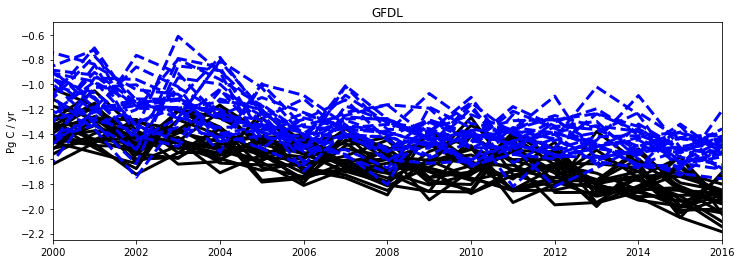

In [25]:
fig = plt.subplots(1,1,figsize=(12,4))

plt.plot(range(1983,2017),annual_fluxes_truth_GFDL.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='mean truth CanCESM2', color='black')
plt.plot(range(1983,2017),annual_fluxes_recon_GFDL.mean(["wind", "ensemble"])/(1e15),linewidth=3, label='recon CanCESM2', color='blue', linestyle='--')


# plt.grid(True)
plt.title(f"GFDL")
#plt.legend()
plt.ylabel('Pg C / yr')
plt.ylim(-2.25,-0.5)
plt.xlim(2000,2016)
#plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left');

plt.savefig('/home/theimdal/GFDL_flux_global_historical_bias.png', dpi=300, bbox_inches="tight")